In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets


#### Разработка алгоритма модели SGD - регрессии

In [4]:
#функция масштабирования - нормализация
def st_scaler (matrix):
    
    return (matrix-matrix.mean(axis=0))/matrix.std(axis=0)

In [5]:
#функция расчета оштбки -r2
def r_2(y_pred, y_true):
    numerator = ((y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    denominator = ((y_true - np.average(y_true)) ** 2).sum(axis=0,
                                                          dtype=np.float64)
    return 1 - (numerator / denominator)

In [6]:
#функция вывода на печать графика изменения MSE при обучении модели
def plot_mse (model):
    fig = plt.figure(figsize=(15, 5))
    plt.title("SGD Regressor", size=15)
    plt.plot(model.errors_history, label="SGD Rige")
    plt.legend(loc="best", fontsize=15)
    plt.xlabel("n_iterations", size=15)
    plt.ylabel("MSE", size=15)
    plt.xlim(0, 500)

In [7]:
# Реализация класса SGD- регрессора
class SGD_regressor:
    def __init__(self, alpha=0.01,
                 max_iter=1000,
                 penalty='l2',
                 batch=35,
                 tol=0.001,
                 l2_coef = 0.01,
                 l1_coef=0.01,
                 fit_intercept=True):
        self.alpha = alpha  # шаг градиентного спуска
        self.max_iter = max_iter  # максимальное число итераций
        #self.min_weight_dist = min_weight_dist = 1e-8  # критерий сходимости (разница весов, при которой алгоритм останавливается)
        self.penalty = penalty  # параметр для регуляризации (по выбору: "l1", "l2", "elasticnet")
        self.qty_in_batch = batch  # Размер выборки для одной итерации оптимизатора
        self.w = []  # матрица коэфициентов регрессионной модели
        self.errors_history = []
        self.l2_coef = 0 if self.penalty=='l1' else l2_coef  #коэфициент L2- регуляризации
        self.l1_coef = 0 if self.penalty=='l2' else l1_coef #коэфицинт L1- регуляризации
        self.tol = tol  # Минимальное значимое изменение ошибки, при котором обучение продолжается.
        self.fit_intercept= fit_intercept # указатель необходимости расчета интерсепта (по умолчанию True)
  

    # метод, который трансформирует приниаемый на вход модели DateFrame в Numpy массив и добавляет
    # свободный коэфициент для intercept.
    def transform_df(self, X_frame):
        #X_frame["intercept"] = 1

        return X_frame.to_numpy()

    # метод, который считает MSE.
    def calculate_mse(self, y_true: np.array, y_pred: np.array) -> float:
        assert len(y_true) == len(y_pred)
        mse = np.mean(np.square(y_true - y_pred))

        return mse
    
                

    # метод обучения модели
    def fit(self, X_frame, y_frame):
        X = self.transform_df(X_frame) if type(X_frame) == pd.core.frame.DataFrame else X_frame  # преобразуем DataFrame
        if self.fit_intercept: #добавим в матрицу признаков столбец из 1 для коэфициента интерсепта
            X=np.append(X, np.ones((X.shape[0],1)),1)
        self.w = np.random.randn(X.shape[1])  # инициируем вектор начальных коэфициентов
        y = y_frame.to_numpy().T[0] if type (y_frame)==pd.core.frame.DataFrame else y_frame
        
        n_batches = len(y) // self.qty_in_batch

        if len(y) % self.qty_in_batch:
            n_batches += 1

        for n_iter in range(1,self.max_iter+1):
            for batch_number in range(n_batches):
                x_batch = X[batch_number*self.qty_in_batch:(batch_number+1)*self.qty_in_batch]
                y_batch = y[batch_number*self.qty_in_batch:(batch_number+1)*self.qty_in_batch]

                y_pred = np.dot(self.w, x_batch.T)
                current_error = self.calculate_mse(y_batch, y_pred)

                self.w -= 2*self.alpha*(np.sum(x_batch.T*(y_pred - y_batch), axis=1)/len(y_pred) 
                                        + 2*self.l2_coef*self.w+self.l1_coef*np.sign(self.w))
                self.errors_history.append(current_error)


            if n_iter > 2 and np.abs(current_error - self.errors_history[-2]) < self.tol:
                break

        return self

    def predict(self, X_frame):
        x = self.transform_df(X_frame) if type(X_frame) == pd.core.frame.DataFrame else X_frame
        if self.fit_intercept:
            x=np.append(x, np.ones((x.shape[0],1)),1)
        y=np.dot(self.w, x.T)
       
        return y.T

#### Проведем валидацию алгоритма SGDRegressor на искуственно созданных данных

In [1611]:
# сгенерируем набор данных
data, target, coef = datasets.make_regression(
    n_samples=20000,
    n_features=5,
    n_targets=1,
    noise=10,
    coef=True,
    random_state=29
)

In [1612]:
coef

array([36.33007175, 54.47402258,  0.63528725, 46.83225617, 20.8944268 ])

In [1613]:
#Произведем стандартизацию признаков
data_st1 = st_scaler(data)

In [1614]:
#проверка функции масштабирования
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)

data_st2 =scaler.transform(data)
data_st1-data_st2

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [1616]:
#разбиваем данные на nестовую и тренировочную выборки
train_x, test_x, train_y, test_y = train_test_split(data_st1,target,test_size = 0.5, random_state = 1)

In [1617]:
# инициализируем и обучаем модель SDG - регрессии, размер батча - корень из объема выборки
model1=SGD_regressor(batch=int((train_x.shape[0])**(1/2)),penalty='elasticnet', max_iter=1000 )
model1.fit(train_x, train_y)

In [1618]:
model1.w, coef

(array([35.48307492, 53.79287798,  0.4756791 , 46.09092652, 20.71053123,
         0.33458853]),
 array([36.33007175, 54.47402258,  0.63528725, 46.83225617, 20.8944268 ]))

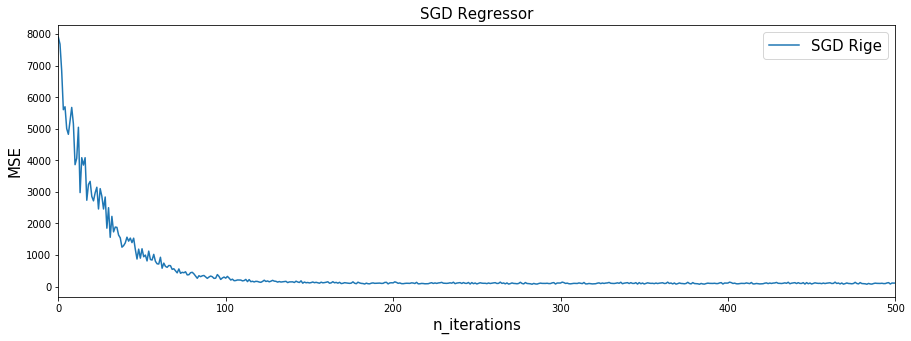

In [1619]:
plot_mse (model1)

##### Вывод: алгоритм сошелся

In [1620]:
# спрогнозируем значение целевой переменной на тренировочных данных
y_train_pred = model1.predict(train_x)

Рассчет ошибки R2 на тренировочных данных

In [1621]:
r2_score_train = r_2(y_train_pred, train_y)
r2_score_train


0.9853888384540058

Проверим модель на тестовых данных

In [1622]:
y_test_pred = model1.predict(test_x)

Рассчет ошибки R2 на тестовых данных

In [1624]:
r2_score_test = r_2(y_test_pred, test_y)
r2_score_test

0.985708917424525

#### Вывод: алгоритм SGDRegressor показывает высокие результаты по R2-score как на тренировочной, так и на тестовой выборках из искуственно созданных данных, обладающих линейной зависимостью

### Работаем с основным датасетом

In [28]:
#функция печати корреляционной матрицы
def print_corr_matrix(corr, v_max=0.7):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=v_max, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

выполняем необходимые загрузки данных

In [29]:
test_data_link =r'test_data/test.csv'
train_data_link = r'train_data/train.csv'
result_data_link = r'test_data/submission.csv'

In [30]:
test_data=pd.read_csv(test_data_link)

In [31]:
train_data_main = pd.read_csv(train_data_link)


In [32]:
train_data = train_data_main.copy()

Разведочный анализ данных

In [33]:
train_data.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [35]:
train_data.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,64.340800
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,13.536823
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


**Данные структурированы, пропусков в данных нет**

Анализ распределения целевой переменной и корреляционных взаимосвязей признаков и целевой переменной

In [36]:
corr = train_data.corr()

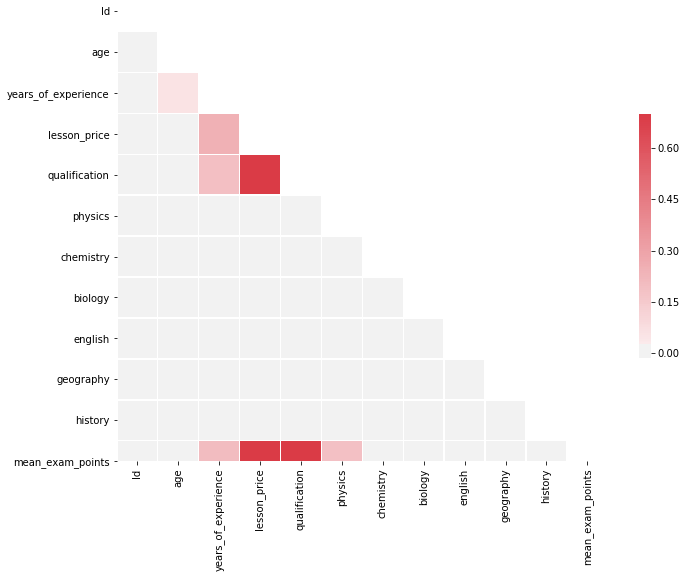

In [37]:
print_corr_matrix(corr)

Вывод: Наибольшая корреляция целевой переменной отмечается с признаками: **lesson_price, qualification, years_of_experience и physics**. При этом, признаки **lesson_price, qualification достаточно сильно коррелируют между собой**

Распределение целевой переменной в зависимости от параметра qualification

In [38]:
df_qual1=train_data[train_data['qualification']==1]['mean_exam_points']
df_qual2=train_data[train_data['qualification']==2]['mean_exam_points']
df_qual3=train_data[train_data['qualification']==3]['mean_exam_points']
df_qual4=train_data[train_data['qualification']==4]['mean_exam_points']

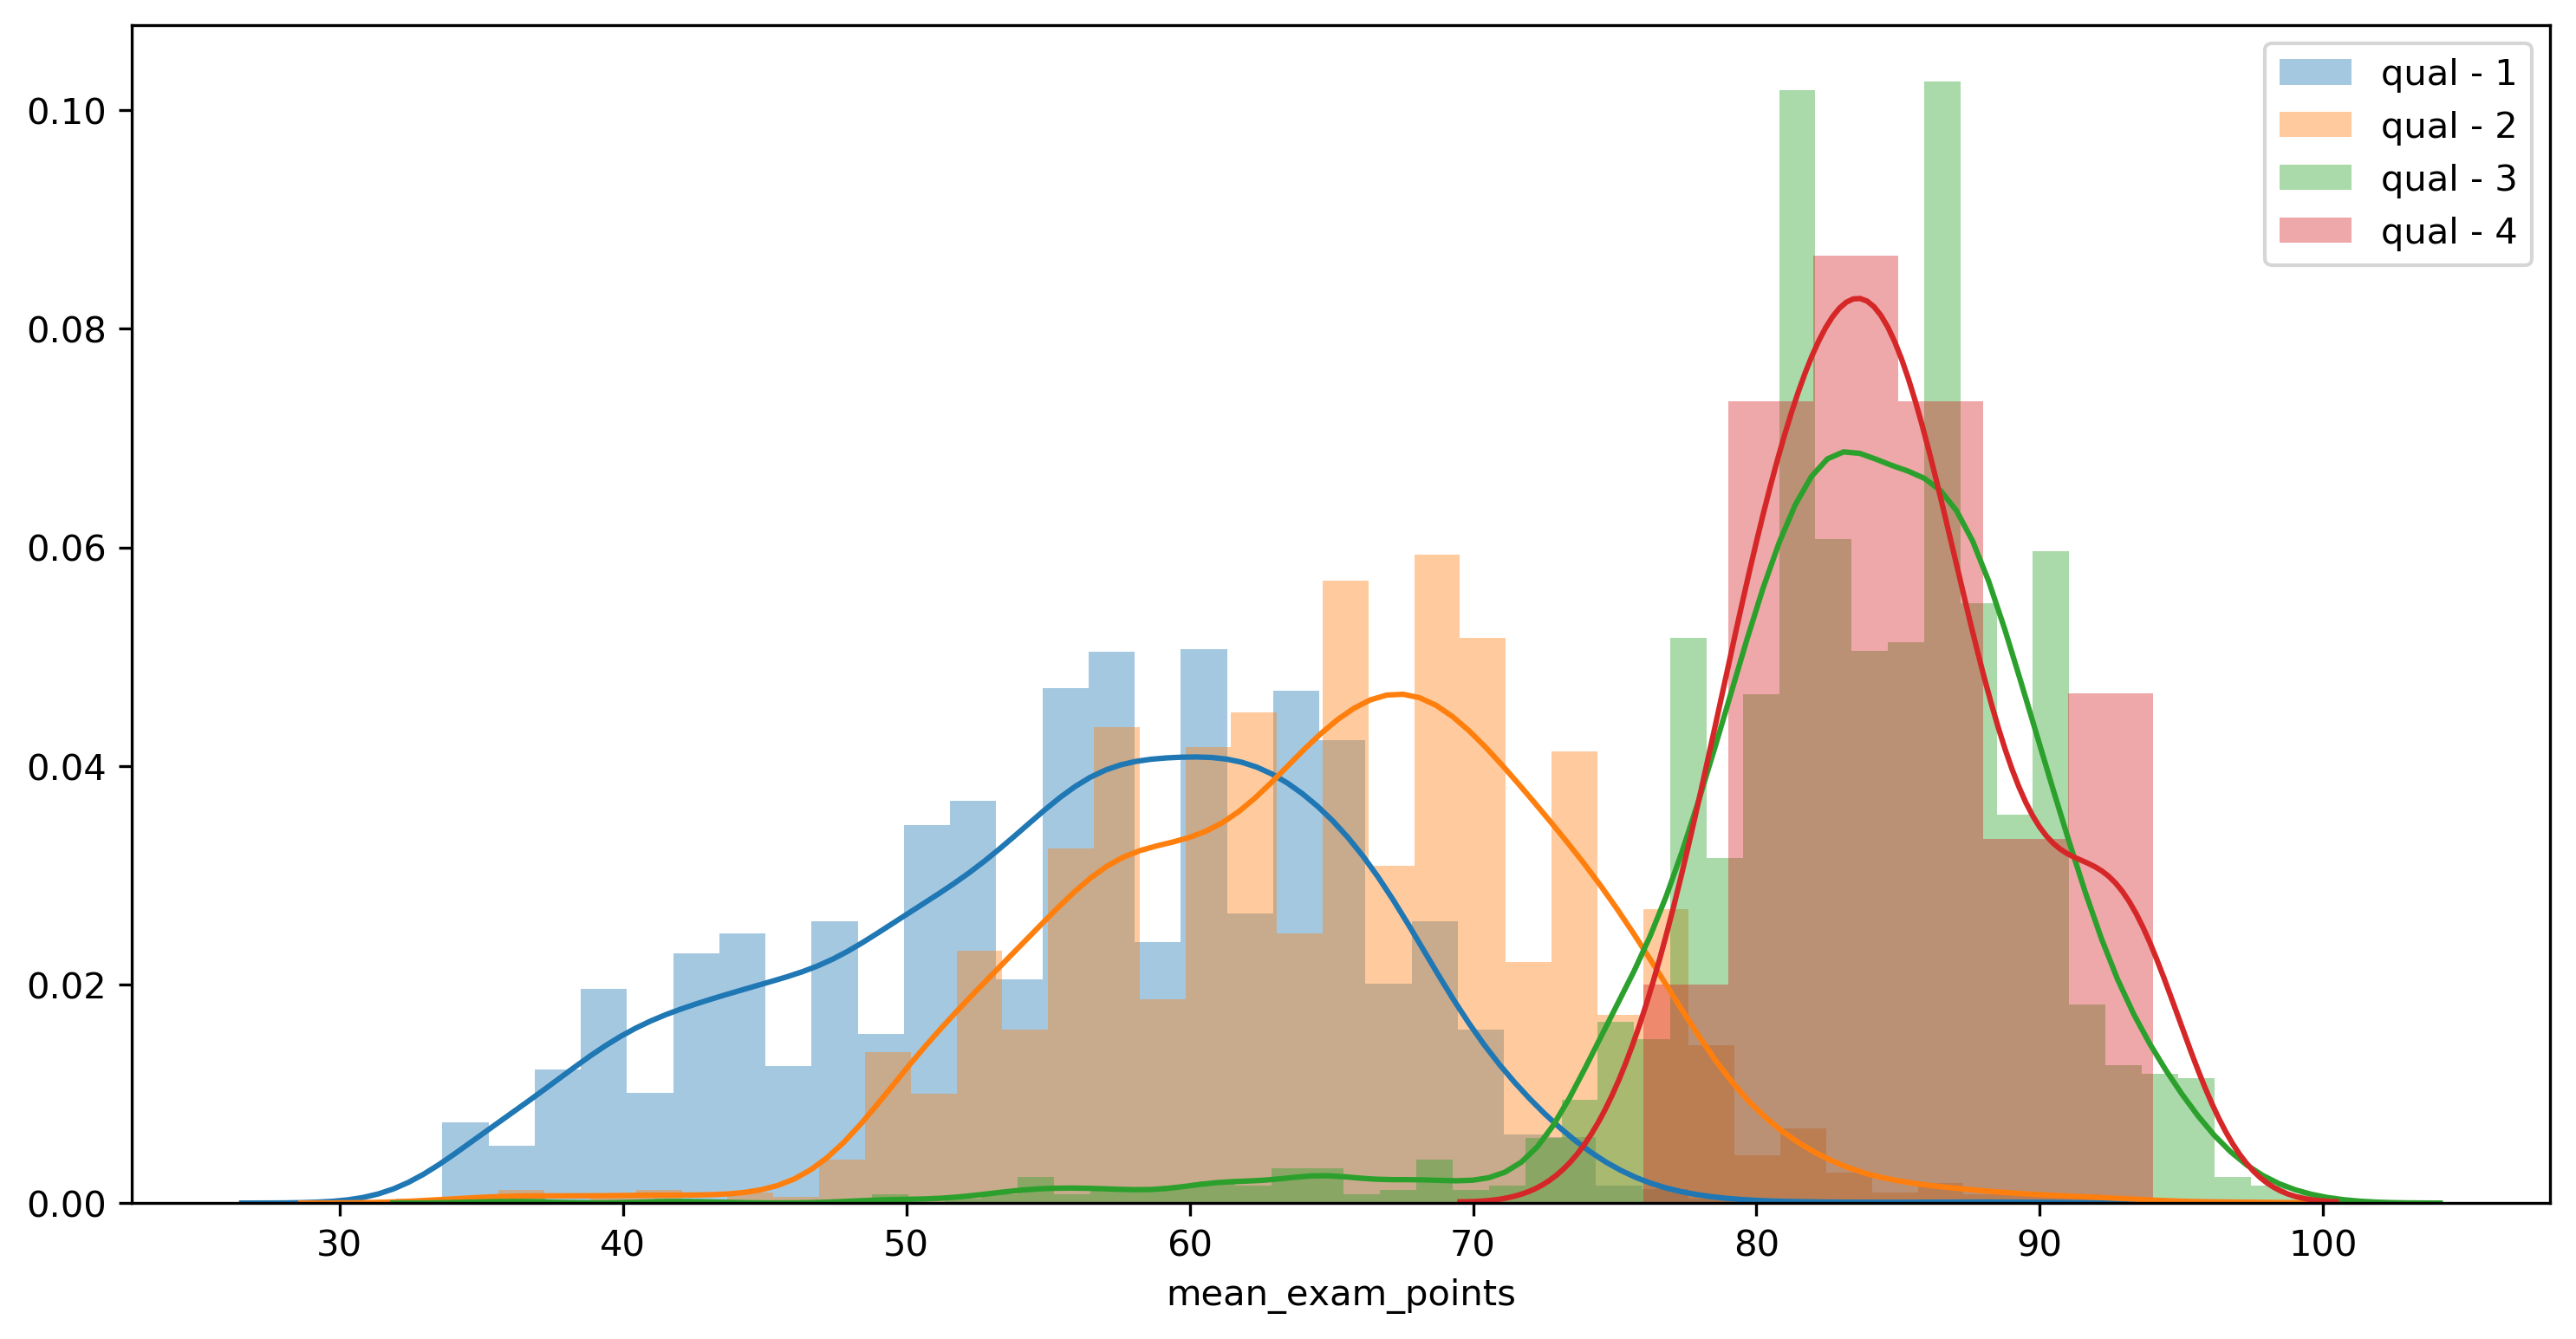

In [39]:
fig, axes = plt.subplots(figsize=(12,6), dpi=300)
sns.distplot(df_qual1, label="qual - 1")
sns.distplot(df_qual2, label="qual - 2")
sns.distplot(df_qual3, label="qual - 3")
sns.distplot(df_qual4, label="qual - 4")
plt.legend();

Вывод. Имеет место схожесть распределения для квалификации 3,4. Можно ввести дополнительный категориальный признак: квалификация > 2 или нет

Изучим, как зависит целевая переменная от признака 'lesson_price' в разрезе квалификации

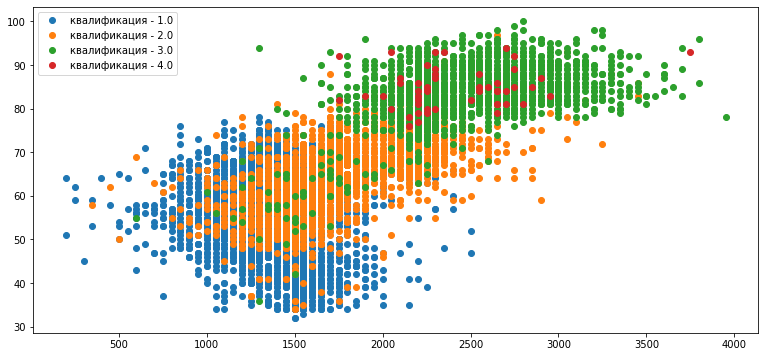

In [47]:
plt.figure(figsize=(13, 6))
groups = train_data.groupby("qualification")
for name, group in groups:
    plt.plot(group["lesson_price"], group["mean_exam_points"], marker="o", linestyle="", label=f'квалификация - {name}')
plt.legend()

In [41]:
#выделяем целевую переменную в отдельный Frame
y_target_train=train_data.loc[0:,'mean_exam_points']

In [42]:
# функция генерации дополнительных признаков на основе существующих
def feature_generation (train_data_main):
    train_data_main['log_lesson_price']=np.log(train_data_main['lesson_price'])
    train_data_main['sqr_lesson_price']=np.sqrt(train_data_main['lesson_price'])
    train_data_main['qulification_total']=train_data_main['physics']+train_data_main['chemistry']+train_data_main['biology']+train_data_main['english']+train_data_main['geography']+train_data_main['history']
    train_data_main['is_expirienced']=(train_data_main['qulification_total']> 0).astype('int64')
    train_data_main['highly_qualified']=(train_data_main['qualification']> 2).astype('int64')
    train_data_main['is_old']=(train_data_main['age']>train_data_main['age'].quantile(.75)).astype('int64')
    train_data_main['is_young']=(train_data_main['age']<train_data_main['age'].quantile(.25)).astype('int64')
    train_data_main['qualification_in_physics']=train_data_main["physics"]*train_data_main['qualification']
    train_data_main['expirience_in_physics']=train_data_main["physics"]*train_data_main['years_of_experience']
    train_data_main['qual_vs_experience_in_ph']=train_data_main["expirience_in_physics"]*train_data_main['qualification_in_physics']
    train_data_main['qual_for_money']=train_data_main['lesson_price']*(np.exp(train_data['qualification']))
    train_data_main['is_expensive']=(train_data_main['lesson_price']>train_data_main['lesson_price'].quantile(.75)).astype('int64')
    train_data_main['is_chip']=(train_data_main['lesson_price']<train_data_main['lesson_price'].quantile(.25)).astype('int64')
    train_data_main=train_data_main.drop(['Id'], axis=1)

    return train_data_main



In [43]:
train_data = feature_generation(train_data)

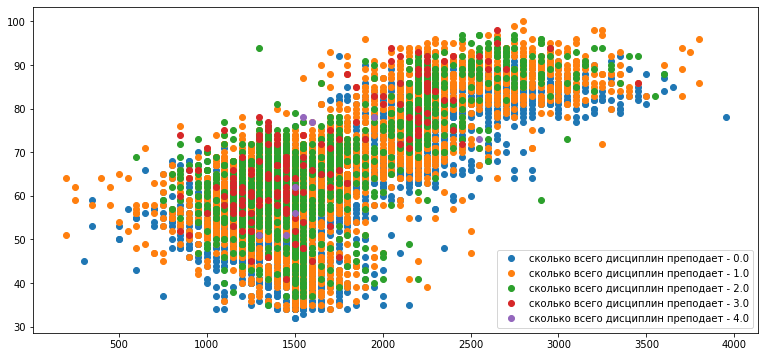

In [46]:
plt.figure(figsize=(13, 6))
groups = train_data.groupby("qulification_total")
for name, group in groups:
    plt.plot(group["lesson_price"], group["mean_exam_points"], marker="o", linestyle="", label=f'сколько всего дисциплин преподает - {name}')
plt.legend()

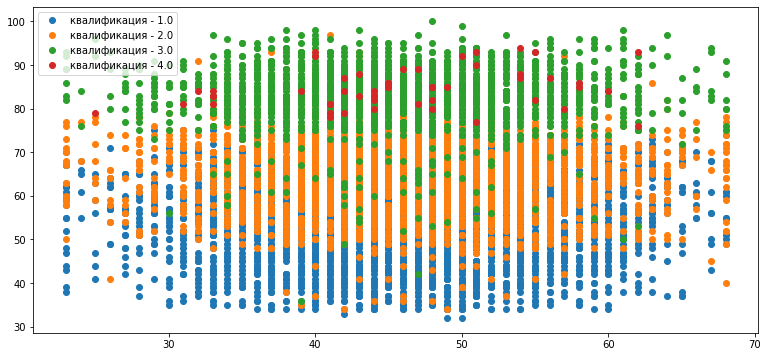

In [51]:
plt.figure(figsize=(13, 6))
groups = train_data.groupby("qualification")
for name, group in groups:
    plt.plot(group["age"], group["mean_exam_points"], marker="o", linestyle="", label=f'квалификация - {name}')
plt.legend()

In [23]:
train_data=train_data.drop(['mean_exam_points'], axis=1)

#### стандартизация признаков

In [1682]:
train_data_st = st_scaler(train_data)

In [1683]:
#преобразуем целевую переменную в numpy array
y_target_train=y_target_train.to_numpy()

Разобьем на тестовую и тренировочную выборки

In [1684]:
train_x, test_x, train_y, test_y = train_test_split(train_data_main_st, y_target_train,test_size = 0.3, random_state = 3)

Инициализируем и обучем регрессионную модель SGD

In [1685]:
model_sgd_main=SGD_regressor(batch=int((train_x.shape[0])**(1/2)),penalty='l2', max_iter=1000)
model_sgd_main.fit(train_x, train_y)

In [1686]:
model_sgd_main.w

array([-7.67676828e-02,  8.37119858e-02,  2.98523910e+00,  4.34371058e+00,
        1.50324674e+00, -1.00423963e-01,  1.30267680e-02,  2.51684965e-02,
       -7.18345671e-02, -2.48634765e-02, -1.02769124e+00,  1.35173189e+00,
        9.19777489e-01,  1.91906605e-01,  2.32700664e+00, -3.73837567e-02,
       -1.70864935e-03,  1.63094819e-01, -1.57367407e-01,  4.14357575e-01,
        1.75815592e-01,  1.75272535e+00,  7.43552478e-01,  6.31003917e+01])

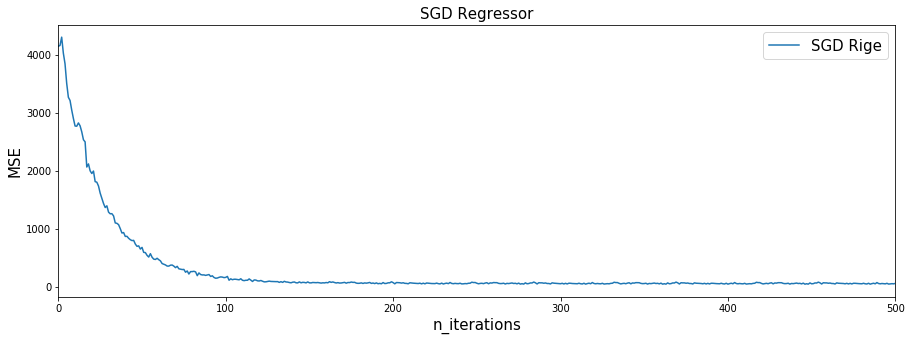

In [1687]:
plot_mse(model_sgd_main)

Рассчитаем качество модели R2 на тренировочной выборке

In [1688]:
y_train_pred = model_sgd_main.predict(train_x)

In [1689]:
r2_score_train = r_2(y_train_pred, train_y)
r2_score_train

0.662211343963388

проверяем на тестовой выборке

In [1690]:
y_test_pred = model_sgd_main.predict(test_x)

In [1691]:
r2_score_test = r_2(y_test_pred, test_y)
r2_score_test

0.6685620268149794

**Вывод: качество модели на тренировочной и тестовой выборках сопоставимо**

Обучаем модель на всем объеме тестового датафрейма

In [1692]:
model_sgd_main.fit(train_data_st, y_target_train)

### Предсказание на тестовых данных

Обработка данных и генерирование признаков

In [1696]:
test_data_ = test_data.copy()

In [1697]:
test_data_ = feature_generation (test_data_)

In [1698]:
test_data_st = st_scaler(test_data_)

In [1699]:
y_test_pred = model_sgd_main.predict(test_data_st)

In [1723]:
submission = pd.DataFrame({"Id":[id for id in range (10000, 20000)], "mean_exam_points":np.rint(y_test_pred)})

In [1]:
submission.to_csv(result_data_link, index = False)

NameError: name 'submission' is not defined